## Reproduction work

In this work we aim to reconstruct the results presented in figure 2 of Korda and Mezic (2018), a paper on _linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control_. 

In [2]:
%load_ext autoreload
%autoreload 2
# perform relevant imports
import Dictionaries
import methods
import System
import utils
import plot_data
import tools

import numpy
import matplotlib.pyplot as plt
import scipy.signal
numpy.random.seed(2141444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data is collected using functions in `System.py`. The differential equation for this work is the forced Van der Pol oscillator, a chaotic system defined by
$$ \dot x_1 = x_2 $$ 
$$ \dot x_2  = -0.8 x_1 + 2 x_2 - 10 x_1^2 x_2 + u $$

1500 trajectories of this system are initialised, for which 200 time-steps are simulated at a timestep of $dt = 0.01$. Data is stored in `testdata/Korda2018.mat` to speed up execution. Basis functions consist of 100 thin plate radial basis functions 
$$ \| x - x_0 \|^2 \log ( \| x - x_0 \| ) $$

The plot shows 5 example trajectories combined with the origins of the basis functions.

Key 'Generate' not found in system construction
Generating new dataset


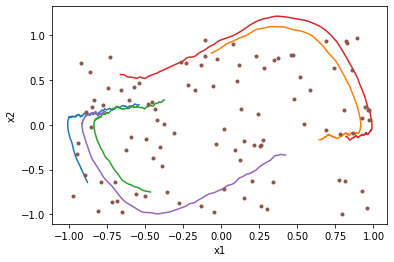

In [4]:
# Initialise data structure for Korda van der Pol estimate.
# 2, states, 1 input
# 200 timesteps for 1000 trajectories in training data with dt = 0.01
KordaEquation = System.differentialEquation(System.forcedvanDerPolSystemKorda, 2, 1)
Korda         = System.System(KordaEquation, 'testdata/Korda2018.mat', 200, 1500, 0.01, Generate=False)

# Initialise radial basis functions, 100 with 2 states in box [-1,1]^2
tprbf_dict = Dictionaries.thin_plate_rbf_dictionary(2, 100, 2)

plt.plot(Korda.StateSequence[0:5,0,:].T, Korda.StateSequence[0:5,1,:].T, '-', tprbf_dict.origins[:,0,:], tprbf_dict.origins[:,1,:], '.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Compute the DMD estimate using the initialised data, and compute validation parameters using validation data split

In [5]:
# Compute DMD estimate from data
A, B, C = methods.testControlledMethod(methods.compute_Korda2018, Korda, tprbf_dict, 0)

1000
1000
1000


In [30]:
#Compute validation 
vaf, rmse, rrmse = methods.linear_Validate(A, B, Korda, tprbf_dict, 0, C=C)

  0%|          | 0/1000 [00:00<?, ?it/s]

We aim to reproduce the numerical example figure in Korda2018. The input is a square-wave forcing with period of 60 seconds. The figure below shows the true evolution, computed with a RK4(5) dynamic solver, the static RK4 solution used in the original paper, the Koopman estimate with the first 2 initial states and teh Koopman estimate using an optimised $C$-matrix

Lifting dynamics
(102, 1)
1


C:\Users\menno\.conda\envs\networked\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


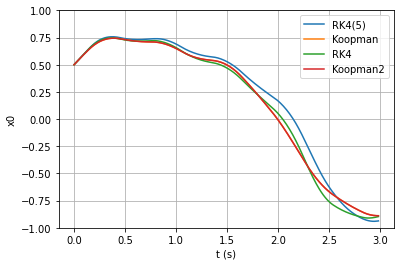

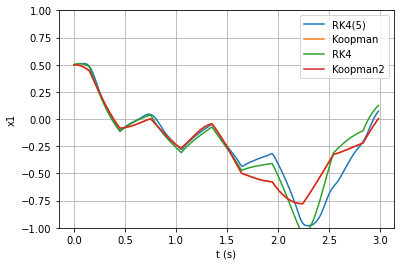

In [25]:
u_square = scipy.signal.square(numpy.linspace(0, 10 * numpy.pi, int(3 // Korda.dt)))
u_square = numpy.roll(u_square, -u_square.shape[0]// (5 * 4))
x0 = numpy.array([0.5, 0.5])

t_out, y_est, y_comp, y_est2 = methods.linear_compare(A, B, Korda, tprbf_dict, 0, x0, u_square.reshape((1,u_square.shape[0])), C=C)
t, y = tools.integrate_RK(KordaEquation.EvolutionFunction, x0, u_square, 0.01)

plot_data.compareTrajectories(t_out, y_comp, y_est, y, y_est2, Names=["RK4(5)", "Koopman", "RK4", "Koopman2"])

In [31]:
print("Average RRMSE: %.2f +- %.2f" % (numpy.mean(rrmse), numpy.sqrt(numpy.var(rrmse))))
print("Average VAF in x1: %.2f +- %.2f" % (numpy.mean(vaf[0,:]), numpy.sqrt(numpy.var(vaf[0,:]))))
print("Average VAF in x2: %.2f +- %.2f" % (numpy.mean(vaf[1,:]), numpy.sqrt(numpy.var(vaf[1,:]))))


Average RRMSE: 0.24 +- 0.19
Average VAF in x1: 0.97 +- 0.00
Average VAF in x2: 0.91 +- 0.05


Our results are comparative to the results in the original paper. The example trajectory has worse performance in the second state variable at the same number of basis functions (100). Furthermore, the Relative Root Mean Square error is also slightly worse. The high normal deviation of $\sigma = 0.18$ is also relatively high, which is not reported on in the original work.

This difference is attributed to the chosen seed in the original work. Removing this seed in the provided original code, a similar variation in performance is recovered.